#Import

In [1]:
# if open from google colab, run this command
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/data-retail
# %cd /content/drive/MyDrive/Github/sales-prediction-gru/ipynb
# %cd /content/drive/Shareddrives/BUAT\ DIEGO/Data-retail-2015-2022-keluar/

Mounted at /content/drive
/content/drive/MyDrive/data-retail


In [2]:
import os, warnings, random

import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras import optimizers, Sequential, Model, callbacks
from tensorflow import keras
from keras.models import Sequential
from keras import Input
from keras.layers import Bidirectional, GRU, RepeatVector, Dense, TimeDistributed 

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline 

import plotly as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

import joblib
from keras.models import load_model

pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# df2016 = pd.read_csv('./data-2016-renew.csv', parse_dates=['tgl'])
# df2017 = pd.read_csv('./data-2017-renew.csv', parse_dates=['tgl'])
# df2018 = pd.read_csv('./data-2018-renew.csv', parse_dates=['tgl'])
# df2019 = pd.read_csv('./data-2019-renew.csv', parse_dates=['tgl'])
df2020 = pd.read_csv('./data-2020-renew.csv', parse_dates=['tgl'])
df2021 = pd.read_csv('./data-2021-renew.csv', parse_dates=['tgl'])
df2022 = pd.read_csv('./data-2022-renew.csv', parse_dates=['tgl'])

#Preprocessing

In [4]:
# print("kodekategori 2016: ", df2016['kodekategori'].unique())
# print("kategori 2016: ", df2016['kategori'].unique())
# print("2017: ", df2017['kategori'].unique())
# print("2018: ", df2018['kategori'].unique())
# print("2019: ", df2019['kategori'].unique())
# print("2020: ", df2020['kategori'].unique())

In [5]:
# get unique kategori value

# group_kategori2016 = df2016.groupby('kodekategori')['kategori'].unique().reset_index()
# group_kategori2017 = df2017.groupby('kodekategori')['kategori'].unique().reset_index()
# group_kategori2018 = df2018.groupby('kodekategori')['kategori'].unique().reset_index()
# group_kategori2019 = df2019.groupby('kodekategori')['kategori'].unique().reset_index()
group_kategori2020 = df2020.groupby('kodekategori')['kategori'].unique().reset_index()
group_kategori2021 = df2021.groupby('kodekategori')['kategori'].unique().reset_index()

# pdList = [group_kategori2016, group_kategori2017, group_kategori2018, group_kategori2019, group_kategori2020, group_kategori2021]
pdList = [group_kategori2020, group_kategori2021]

new_kategori = pd.concat(pdList).reset_index(drop=True)
new_kategori['kodekategori'] = new_kategori['kodekategori'].astype(float)
new_kategori['kategori'] = new_kategori['kategori'].astype(str)

clean_kategori = new_kategori.drop_duplicates(subset=['kodekategori']).reset_index(drop=True)

In [6]:
display(clean_kategori.T)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115
kodekategori,101.00,102.00,103.00,104.00,105.00,106.00,107.00,108.00,109.00,110.00,111.00,112.00,113.00,114.00,115.00,201.00,202.00,203.00,204.00,205.00,206.00,301.00,302.00,10101.00,10102.00,10103.00,10104.00,10105.00,10106.00,10107.00,10108.00,10109.00,10110.00,10111.00,10112.00,10113.00,10114.00,10115.00,10116.00,10117.00,10118.00,10119.00,10120.00,10121.00,10201.00,10202.00,10203.00,10204.00,10205.00,10206.00,10207.00,10208.00,10209.00,10210.00,10211.00,10212.00,10213.00,20101.00,20201.00,20301.00,20402.00,20501.00,20502.00,20503.00,20504.00,20601.00,30101.00,30201.00,30202.00,30203.00,30204.00,30301.00,30302.00,30303.00,30304.00,30305.00,30306.00,30307.00,30308.00,30309.00,30310.00,30311.00,30312.00,30401.00,30402.00,30403.00,30404.00,30405.00,30406.00,30407.00,40101.00,40103.00,40201.00,40202.00,40203.00,40301.00,40302.00,40303.00,40304.00,40305.00,40306.00,40307.00,40308.00,40309.00,40310.00,40311.00,40312.00,40401.00,40402.00,40403.00,40404.00,40405.00,40501.00,40601.00,20302.00,40502.00
kategori,['Baby Needs'],['Mens Care (2)'],['Healt & Beauty Care (3)'],['Kids Care (4)'],['Cleaning (5)'],['Homes (6)'],['Electronic & Tool kits (7)'],['Automotive (8)'],['Stationery (9)'],['Toys (10)'],['Sports (11)'],['Event Equipment (12)'],['Convection (13)'],['Shoes & Sandals (14)'],['Bag & Luggage (15)'],['Food (1)'],['Beverage (2)'],['Medicine (3)'],['Pets food (4)'],['Cigarette (5)'],['Fresh Food (6)'],['Others (1)'],['alisha collection'],['Makanan Bayi (Baby Food)'],['Bahan Kue (Baking Supplies)'],['Biskuit (Biscuit)'],['Roti dan Kue (Bread & Cake)'],['Sarapan Pagi (Breakfast)'],['Penganan Permen (Candy Confectionary)'],['Penganan Coklat (Chocolate Confectionary)'],['Makanan Mentah (Raw Food)'],['Ice'],['Makanan Masak (Cooked Food)'],['Bumbu Dapur (Seasoning)'],['Mie (Noodle)'],['Pasta'],['Makanan Ringan (Snack)'],['Beras (Rice)'],['Biji-bijian (Seeds)'],['Gula (Sugar)'],['Tepung (Flour)'],['Minyak Goreng (Cooking Oil)'],['Makanan Kaleng (Canned Food)'],['Makanan Hewan (Pet Food)'],['Susu (Milk)'],['Kopi (Coffe)'],['Teh (Tea)'],['Air (Water)'],['Minuman Buah (Juice)'],['Minuman Kesehatan (Healty Drink)'],['Minuman Berenergi (Energy Drink)'],['Minuman Isotonik (Isotonik Drink)'],['Minuman Penyegar (Refreshment)'],['Minuman Jeli (Jelly Drink)'],['Minuman Bersoda (Soft Drink)'],['Minuman Beralkohol (Alcoholic Drink)'],['Sirup (Syrup)'],['Buah (Fruit)'],['Sayur (Vegetable)'],['Daging Merah (Red Meat)'],['Air Tawar'],['Susu & Olahan (Dairy)'],['Harian (Daily)'],['Beku (Frozen)'],['Telur (Egg)'],['Produk Siap Makan (Ready To Eat)'],['Rokok (Cigarete)'],['Obat Dalam (Peroral)'],['Obat Luar (Topikal)'],['Vitamin & Suplemen (Vitamis & Supplements)'],['Alat Kesehatan (Health Appliance)'],['Perawatan Rambut (Hair Care)'],['Perawatan Wajah (Face Care)'],['Kosmetik (Cosmetic)'],['Tisu & Kapas (Tissues & Cotton)'],['Perawatan Gigi & Mulut (Oral Care)'],['Perawatan Tubuh (Body Care)'],['Perawatan Bayi (Baby Care)'],['Perawatan Anak (Kids Care)'],['Popok Bayi (Baby Diapers)'],['Pembalut Wanita (Sanitary Napkins)'],['Popok Dewasa (Adult Diapers)'],['Perawatan Pria (Mens Groming)'],['Perawatan Pakaian (Clothes Care)'],['Perawatan Dapur (Kitchen Care)'],['Perawatan Rumah (House Care)'],['Pengharum Rumah (Home Fragrances)'],['Pembasmi Serangga & Pengendali Hama (Insecti...,['Perawatan Tas & Sepatu Kulit (Leather Care)'],['Perawatan Otomotif (Automotive Care)'],['Mainan Lunak (Soft Toys)'],['Mainan Keras (Hard Toys)'],['Peralatan (Tools)'],['Perlengkapan (Supplies)'],['Fancies'],['Rumah Tangga (House Hold)'],['Dapur (Kitchen)'],['Kamar Mandi (Bath Room)'],['Kamar Tidur (Bed Room)'],['Peralatan & Perl

In [7]:
# initiate the kategori list that will removed from dataset
kategori_remove_name = ["Fresh Food (6)", "Roti dan Kue (Bread & Cake)", "Sarapan Pagi (Breakfast)", "Makanan Mentah (Raw Food)", "Ice", "Makanan Masak (Cooked Food)", "Buah (Fruit)", "Sayur (Vegetable)", "Harian (Daily)", "Beku (Frozen)", "Telur (Egg)", "Produk Siap Makan (Ready To Eat)", "Daging Merah (Red Meat)", "Daging Putih (White Meat)"]
kategori_remove_list = ["206.00", "10104.00", "10105.00", "10108.00", "10109.00", "10110.00", "20101.00", "20201.00", "20502.00", "20503.00", "20504.00", "20601.00", "20301.00", "20302.00"]

In [8]:
kategori_name_df = pd.DataFrame(kategori_remove_name)
# kategori_name_df.to_csv('kategori_delist.csv', index=False)

In [9]:
# drop unnecessary column
# df2017 = df2017.drop(['notxn', 'nonota', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
# df2018 = df2018.drop(['notxn', 'nonota', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
# df2019 = df2019.drop(['notxn', 'nonota', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2020 = df2020.drop(['notxn', 'nonota', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)
df2021 = df2021.drop(['notxn', 'nonota', 'hargajual', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)

In [10]:
# concat 5 dataframe to single df
# df = pd.concat([df2017, df2018, df2019, df2020, df2021]).reset_index(drop=True)
df = pd.concat([df2020, df2021]).reset_index(drop=True)

In [11]:
# remove strange value in each rows from barcode column
df['barcode'] = df['barcode'].str.split(' ').str[0]

In [12]:
df.head(10)

,tgl,namabarang,satuan,qty,barcode,kodejenis,jenis,kodekategori,kategori
0,2020-04-03 19:27:36.123,MASAKO PENYEDAP RS.SAPI/PAK,PAK,1.00,8992770033208,01011108,Bumbu Tabur,10111,Bumbu Dapur (Seasoning)
1,2020-10-21 16:47:57.980,RINSO 770GR ANTINODA,PCS,1.00,8999999401238,03040101,Detergent Bubuk,30401,Perawatan Pakaian (Clothes Care)
2,2020-04-06 17:46:52.900,CAREFREE HLT.FRESH SPR DRY 40S,PCS,1.00,8850007331803,03031001,Panty Liner,30310,Pembalut Wanita (Sanitary Napkins)
3,2020-07-31 19:15:58.547,ELLLIPS VIT HR NUTRI CLR BLS,PCS,2.00,8993417200038,03030105,Vitamin Rambut,30301,Perawatan Rambut (Hair Care)
4,2020-05-22 13:14:43.407,KUSUKA KRIPIK RUMPUT LAUT 60GR*30,PCS,1.00,653314504513,01011401,Snack Modern,10114,Makanan Ringan (Snack)
5,2020-09-03 20:51:42.103,HIT MAT 20S (18+3S),PCS,1.00,8992745120636,03040504,Pembasmi Serangga Elektrik,30405,Pembasmi Serangga & Pengendali Hama (Insectici...
6,2020-03-14 20:47:06.390,SARI ROTI SANDWICH MARGARIN GULA,PCS,1.00,8992907953171,01010406,Sandwich,10104,Roti dan Kue (Bread & Cake)
7,2020-09-21 17:08:36.647,BIORE BF COMFORT MILD SCRUB 100ML,PCS,1.00,8992727006514,03030605,Sabun Mandi Cair Aromatic,30306,Perawatan Tubuh (Body Care)
8,2020-02-02 20:47:39.680,SUNLIGHT EXTRA PURE REFF 24*175ML,PCS,1.00,8999999549510,03040201,Sabun Cair,30402,Perawatan Dapur (Kitchen Care)
9,2020-01-02 10:53:20.687,IZZI F MIST SECRET CRUSH 100ML,PCS,1.00,8992856899087,03031206,Cologne,30312,Perawatan Pria (Mens Groming)


In [13]:
# create new column named "month_year" to get number of month and year
df['month_year'] = df['tgl'].apply(lambda x: x.strftime('%m-%y')).astype(str)

In [14]:
# transform the value to number of month from all rows
# 2020-2021
df['month_year'] = df['month_year'].map({'01-20':0,'02-20':1,'03-20':2,'04-20':3,'05-20':4,'06-20':5,'07-20':6,'08-20':7,'09-20':8,'10-20':9,'11-20':10,'12-20':11,
                                          '01-21':12,'02-21':13,'03-21':14,'04-21':15,'05-21':16,'06-21':17,'07-21':18,'08-21':19,'09-21':20,'10-21':21,'11-21':22,'12-21':23,})

In [15]:
# drop unnecessary kategori #tidak diremove
# df = df[~df['kategori'].isin(kategori_remove_name)].reset_index(drop=True)

In [16]:
display(df.info())
display(df.head())
# RangeIndex: 11533836 entries, 0 to 11533835 sebelum nambah daftar kategori

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3784003 entries, 0 to 3784002
Data columns (total 10 columns):
 #   Column        Dtype         
---  ------        -----         
 0   tgl           datetime64[ns]
 1   namabarang    object        
 2   satuan        object        
 3   qty           float64       
 4   barcode       object        
 5   kodejenis     object        
 6   jenis         object        
 7   kodekategori  int64         
 8   kategori      object        
 9   month_year    int64         
dtypes: datetime64[ns](1), float64(1), int64(2), object(6)
memory usage: 288.7+ MB


None

,tgl,namabarang,satuan,qty,barcode,kodejenis,jenis,kodekategori,kategori,month_year
0,2020-04-03 19:27:36.123,MASAKO PENYEDAP RS.SAPI/PAK,PAK,1.00,8992770033208,01011108,Bumbu Tabur,10111,Bumbu Dapur (Seasoning),3
1,2020-10-21 16:47:57.980,RINSO 770GR ANTINODA,PCS,1.00,8999999401238,03040101,Detergent Bubuk,30401,Perawatan Pakaian (Clothes Care),9
2,2020-04-06 17:46:52.900,CAREFREE HLT.FRESH SPR DRY 40S,PCS,1.00,8850007331803,03031001,Panty Liner,30310,Pembalut Wanita (Sanitary Napkins),3
3,2020-07-31 19:15:58.547,ELLLIPS VIT HR NUTRI CLR BLS,PCS,2.00,8993417200038,03030105,Vitamin Rambut,30301,Perawatan Rambut (Hair Care),6
4,2020-05-22 13:14:43.407,KUSUKA KRIPIK RUMPUT LAUT 60GR*30,PCS,1.00,653314504513,01011401,Snack Modern,10114,Makanan Ringan (Snack),4


In [17]:
# df_outlier = df.query('qty > 0 & qty <= 50')
# sns.set(rc={'figure.figsize':(20,6)})
# sns.boxplot(x='month_year', y='qty', data=df_outlier)

In [18]:
# df['satuan'].unique()

In [19]:
# df_kg = df[df['satuan'] == "KG"]
# df_kg.info()

In [20]:
# ax = sns.boxplot(x='kategori', y='qty', data=df)
# ax.set_xticklabels(ax.get_xticklabels(),rotation=90)

In [21]:
train_monthly = df[['tgl', 'month_year', 'kodejenis', 'barcode', 'qty']].copy()
train_monthly = train_monthly.sort_values('tgl').groupby(['month_year', 'kodejenis', 'barcode'], as_index=False)
train_monthly = train_monthly.agg({'qty':['sum']})
train_monthly.columns = ['month_year', 'kodejenis', 'barcode', 'qty_cnt']
train_monthly = train_monthly.query('qty_cnt > 0 and qty_cnt <= 50')

train_monthly['qty_cnt_month'] = train_monthly.sort_values('month_year').groupby(['barcode', 'kodejenis'])['qty_cnt'].shift(-1)

display(train_monthly.head())

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,month_year,kodejenis,barcode,qty_cnt,qty_cnt_month
0,0,01010101,089686640007,30.00,24.00
1,0,01010101,089686640014,30.00,34.00
2,0,01010101,089686640045,12.00,12.00
3,0,01010101,089686646047,7.00,3.00
4,0,01010101,089686646061,5.00,6.00


In [22]:
monthly_series = train_monthly.pivot_table(index=['barcode', 'kodejenis'], columns='month_year',values='qty_cnt', fill_value=0).reset_index()
monthly_series.head()

month_year,barcode,kodejenis,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,00100809,01011601,12.75,10.78,27.13,32.93,18.57,11.34,13.62,12.14,8.19,4.22,2.76,3.97,7.23,3.75,5.23,5.37,4.12,2.11,2.75,5.56,4.12,3.13,1.68,3.59
1,00113731,02020101,3.62,2.89,3.61,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.75,0.78,0.45,1.72,0.32
2,00129213,02010113,0.00,0.00,5.13,0.60,2.79,8.18,0.00,0.00,0.00,4.83,7.70,1.50,38.39,0.00,1.95,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,00133173,02010137,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,47.26,0.00,0.00,0.00,0.00
4,00133210,02010113,0.00,0.00,1.00,2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [23]:
monthly_series_drop = monthly_series.drop(['kodejenis'], axis=1)

In [24]:
summed_data = monthly_series_drop.groupby('barcode').agg('sum').reset_index(False)
summed_data.head()

month_year,barcode,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,00100809,12.75,10.78,27.13,32.93,18.57,11.34,13.62,12.14,8.19,4.22,2.76,3.97,7.23,3.75,5.23,5.37,4.12,2.11,2.75,5.56,4.12,3.13,1.68,3.59
1,00113731,3.62,2.89,3.61,0.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.75,0.78,0.45,1.72,0.32
2,00129213,0.00,0.00,5.13,0.60,2.79,8.18,0.00,0.00,0.00,4.83,7.70,1.50,38.39,0.00,1.95,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,00133173,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,47.26,0.00,0.00,0.00,0.00
4,00133210,0.00,0.00,1.00,2.00,1.00,3.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [25]:
12+12 #kurang 1 karena bulan terakhir 59

24

# bs8_fm0

In [26]:
first_month = 0
last_month = 23
serie_size = 12
data_series = []

for index, row in summed_data.iterrows():
    for month1 in range((last_month - (first_month + serie_size)) + 1):
        # serie = [row['barcode'], row['kodejenis']]
        serie = [row['barcode']]
        for month2 in range(serie_size + 1):
            serie.append(row[month1 + first_month + month2])
        data_series.append(serie)


columns = ['barcode']
[columns.append(i) for i in range(serie_size)]
columns.append('label')

data_series = pd.DataFrame(data_series, columns=columns)
data_series.head()
data_series = data_series.drop(['barcode'], axis=1)
labels = data_series['label']
data_series.drop('label', axis=1, inplace=True)
train, valid, Y_train, Y_valid = train_test_split(data_series, labels.values, test_size=0.10, random_state=0)
print("Train set", train.shape)
print("Validation set", valid.shape)
az = train.sort_index(axis = 0)
az.head()
X_train = train.values.reshape((train.shape[0], train.shape[1], 1))
X_valid = valid.values.reshape((valid.shape[0], valid.shape[1], 1))

print("Train set reshaped", X_train.shape)
print("Validation set reshaped", X_valid.shape)

Train set (217252, 12)
Validation set (24140, 12)
Train set reshaped (217252, 12, 1)
Validation set reshaped (24140, 12, 1)


In [27]:
def auto_model(batch, neuron, month, first_year, end_year):
  serie_size =  X_train.shape[1] # 12
  n_features =  X_train.shape[2] # 1
  epochs = 1000
  lr = 0.0001

  gru_model = Sequential()
  gru_model.add(L.GRU(neuron, input_shape=(serie_size, n_features)))
  gru_model.add(L.Dense(1, activation='linear'))
  adam = optimizers.Adam(lr)
  gru_model.compile(loss='mse', optimizer=adam, metrics=['accuracy'])

  early_stop = callbacks.EarlyStopping(patience = 10)
  gru_history = gru_model.fit(X_train, Y_train, 
                                validation_data=(X_valid, Y_valid), 
                                batch_size=batch, 
                                epochs=epochs, 
                                verbose=2,
                                callbacks=[early_stop])
  gru_model.save(f"gru_model-bs{batch}_hn{neuron}_month{month}_year{first_year}-{end_year}.h5")

  lstm_train_pred = gru_model.predict(X_train)
  lstm_val_pred = gru_model.predict(X_valid)
  print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
  print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_val_pred)))
  
  fig, ax1 = plt.subplots(1, sharey=True,figsize=(14,7))
  ax1.plot(gru_history.history['loss'], label='Train loss')
  ax1.plot(gru_history.history['val_loss'], label='Validation loss')
  ax1.legend(loc='best')
  ax1.set_title('GRU Model')
  ax1.set_xlabel('Epochs')
  ax1.set_ylabel('MSE')
  plt.show()
  return gru_model

Epoch 1/1000
27157/27157 - 189s - loss: 33.0904 - accuracy: 0.3731 - val_loss: 30.1742 - val_accuracy: 0.4095 - 189s/epoch - 7ms/step
Epoch 2/1000
27157/27157 - 183s - loss: 29.9977 - accuracy: 0.3505 - val_loss: 29.8305 - val_accuracy: 0.3919 - 183s/epoch - 7ms/step
Epoch 3/1000
27157/27157 - 187s - loss: 29.8108 - accuracy: 0.3283 - val_loss: 29.6995 - val_accuracy: 0.3940 - 187s/epoch - 7ms/step
Epoch 4/1000
27157/27157 - 192s - loss: 29.7023 - accuracy: 0.3227 - val_loss: 29.6283 - val_accuracy: 0.3848 - 192s/epoch - 7ms/step
Epoch 5/1000
27157/27157 - 194s - loss: 29.6348 - accuracy: 0.3182 - val_loss: 29.6592 - val_accuracy: 0.2369 - 194s/epoch - 7ms/step
Epoch 6/1000
27157/27157 - 197s - loss: 29.5842 - accuracy: 0.3152 - val_loss: 29.7346 - val_accuracy: 0.4123 - 197s/epoch - 7ms/step
Epoch 7/1000
27157/27157 - 189s - loss: 29.5458 - accuracy: 0.3110 - val_loss: 30.0778 - val_accuracy: 0.2457 - 189s/epoch - 7ms/step
Epoch 8/1000
27157/27157 - 188s - loss: 29.5242 - accuracy: 0.

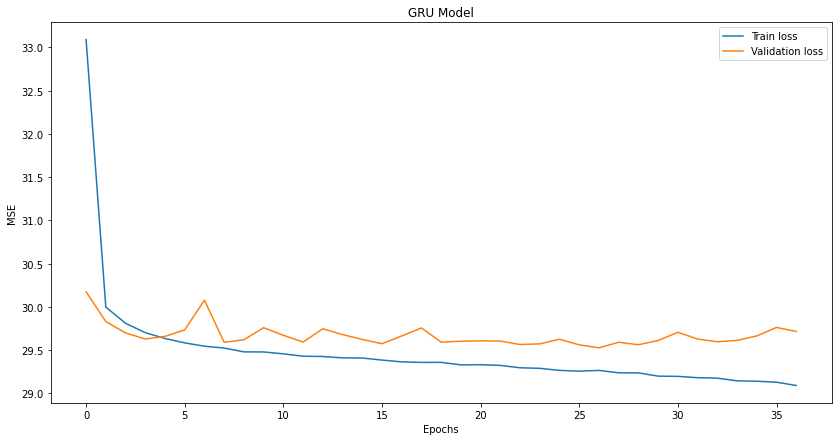

In [ ]:
model1 = auto_model(8, 64, 0, 2020, 2021)

Epoch 1/1000
27157/27157 - 176s - loss: 37.5319 - accuracy: 0.3541 - val_loss: 30.4620 - val_accuracy: 0.3973 - 176s/epoch - 6ms/step
Epoch 2/1000
27157/27157 - 169s - loss: 30.1372 - accuracy: 0.3553 - val_loss: 30.0599 - val_accuracy: 0.3881 - 169s/epoch - 6ms/step
Epoch 3/1000
27157/27157 - 171s - loss: 29.8631 - accuracy: 0.3156 - val_loss: 30.0765 - val_accuracy: 0.3977 - 171s/epoch - 6ms/step
Epoch 4/1000
27157/27157 - 166s - loss: 29.7703 - accuracy: 0.3211 - val_loss: 29.9147 - val_accuracy: 0.2381 - 166s/epoch - 6ms/step
Epoch 5/1000
27157/27157 - 168s - loss: 29.6877 - accuracy: 0.3187 - val_loss: 29.8536 - val_accuracy: 0.3844 - 168s/epoch - 6ms/step
Epoch 6/1000
27157/27157 - 170s - loss: 29.6314 - accuracy: 0.3166 - val_loss: 29.7030 - val_accuracy: 0.2392 - 170s/epoch - 6ms/step
Epoch 7/1000
27157/27157 - 174s - loss: 29.5679 - accuracy: 0.3126 - val_loss: 29.7177 - val_accuracy: 0.2492 - 174s/epoch - 6ms/step
Epoch 8/1000
27157/27157 - 179s - loss: 29.5436 - accuracy: 0.

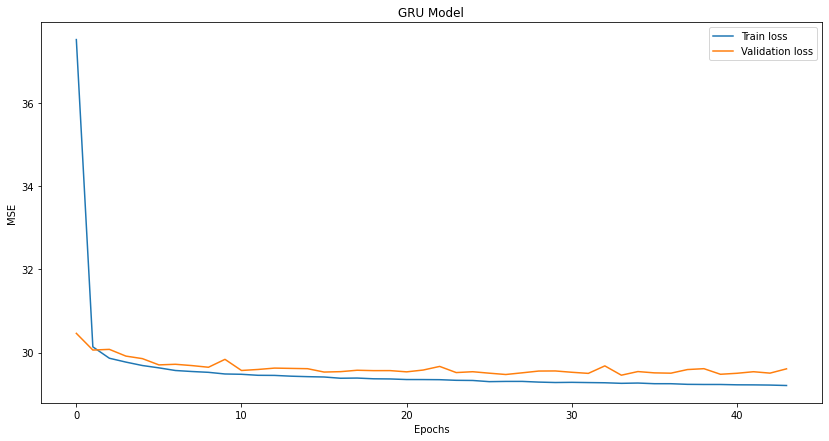

In [28]:
model2 = auto_model(8, 32, 0, 2020, 2021)

Epoch 1/1000
27157/27157 - 183s - loss: 43.3096 - accuracy: 0.3518 - val_loss: 32.0193 - val_accuracy: 0.3891 - 183s/epoch - 7ms/step
Epoch 2/1000
27157/27157 - 172s - loss: 31.0621 - accuracy: 0.3790 - val_loss: 30.4138 - val_accuracy: 0.3866 - 172s/epoch - 6ms/step
Epoch 3/1000
27157/27157 - 174s - loss: 30.2271 - accuracy: 0.3432 - val_loss: 30.1146 - val_accuracy: 0.4017 - 174s/epoch - 6ms/step
Epoch 4/1000
27157/27157 - 174s - loss: 29.9919 - accuracy: 0.3118 - val_loss: 29.9929 - val_accuracy: 0.4046 - 174s/epoch - 6ms/step
Epoch 5/1000
27157/27157 - 171s - loss: 29.8792 - accuracy: 0.3057 - val_loss: 29.8825 - val_accuracy: 0.3993 - 171s/epoch - 6ms/step
Epoch 6/1000
27157/27157 - 175s - loss: 29.8043 - accuracy: 0.3086 - val_loss: 29.8231 - val_accuracy: 0.2405 - 175s/epoch - 6ms/step
Epoch 7/1000
27157/27157 - 167s - loss: 29.7671 - accuracy: 0.3093 - val_loss: 29.7728 - val_accuracy: 0.3983 - 167s/epoch - 6ms/step
Epoch 8/1000
27157/27157 - 170s - loss: 29.7223 - accuracy: 0.

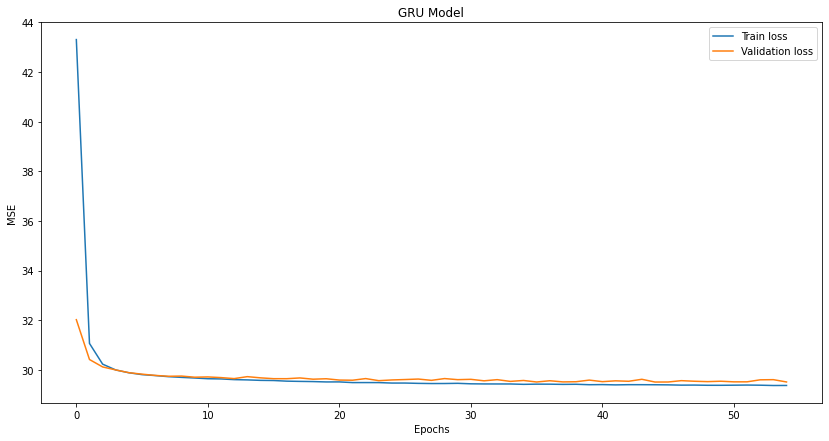

In [29]:
model3 = auto_model(8, 16, 0, 2020, 2021)

In [ ]:
model4 = auto_model(8, 8, 0, 2020, 2021) #run ini

# Test - web fix

In [ ]:
# data preprocessing for prediction january 2022

testing = df2021.copy()

testing['month_year'] = testing['tgl'].apply(lambda x: x.strftime('%m-%y')).astype(str)

testing['month_year'] = testing['month_year'].map({'01-21':0,'02-21':1,'03-21':2,'04-21':3,'05-21':4,'06-21':5,'07-21':6,'08-21':7,'09-21':8,'10-21':9,'11-21':10,'12-21':11})
# testing['month_year'] = testing['month_year'].map({'01-21':'Januari','02-21':'Februari','03-21':'Maret','04-21':'April','05-21':'Mei','06-21':'Juni','07-21':'Juli','08-21':'Agustus','09-21':'September','10-21':"Oktober",'11-21':'November','12-21':'Desember'})

test_monthly = testing[['tgl', 'month_year', 'barcode', 'qty']]
test_monthly = test_monthly.sort_values('tgl').groupby(['month_year', 'barcode'], as_index=False)
test_monthly = test_monthly.agg({'qty':['sum']})
test_monthly.columns = ['month_year', 'barcode', 'qty_cnt']
test_monthly = test_monthly.query('qty_cnt >= 0 and qty_cnt <= 50')

# Label
test_monthly['qty_cnt_month'] = test_monthly.sort_values('month_year').groupby(['barcode'])['qty_cnt'].shift(-1)

test_monthly_series = test_monthly.pivot_table(index=['barcode'], columns='month_year',values='qty_cnt', fill_value=0).reset_index()

In [ ]:
# display(test_monthly_series.nunique())
display(test_monthly_series.head())

month_year,barcode,0,1,2,3,4,5,6,7,8,9,10,11
0,00100809,7.23,3.75,5.23,5.37,4.12,2.11,2.75,5.56,4.12,3.13,1.68,3.59
1,00113731,0.00,0.00,0.00,0.00,0.00,0.00,0.95,0.75,0.78,0.45,1.72,0.32
2,00129213,38.39,0.00,1.95,0.40,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
3,00133173,0.00,0.00,0.00,0.00,0.00,0.00,0.00,47.26,0.00,0.00,0.00,0.00
4,00133210,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [ ]:
# data preprocessing for prediction february 2022

testing_pred = df2022.copy()

testing_pred = testing_pred.drop(['notxn', 'nonota', 'namabarang', 'hargabeli', 'diskon', 'hargaafterdiskon', 'subtotal', 'kodeop', 'isbkp', 'kodecustomer', 'iddistributor', 'idpromo', 'iddivisi', 'jenis', 'kodedepartemen', 'departemen', 'namaop', 'kodedivisibarang', 'divisibarang'], axis=1)

testing_pred['month_year'] = testing_pred['tgl'].apply(lambda x: x.strftime('%m-%y')).astype(str)

testing_pred['month_year'] = testing_pred['month_year'].map({'01-22':0,'02-22':1})

testing_monthly_pred = testing_pred[['tgl', 'month_year', 'barcode', 'qty']]
testing_monthly_pred = testing_monthly_pred.sort_values('tgl').groupby(['month_year', 'barcode'], as_index=False)
testing_monthly_pred = testing_monthly_pred.agg({'qty':['sum']})
testing_monthly_pred.columns = ['month_year', 'barcode', 'qty_cnt']
testing_monthly_pred = testing_monthly_pred.query('qty_cnt >= 0 and qty_cnt <= 50')

# Label
testing_monthly_pred['qty_cnt_month'] = testing_monthly_pred.sort_values('month_year').groupby(['barcode'])['qty_cnt'].shift(-1)

testing_monthly_series_pred = testing_monthly_pred.pivot_table(index=['barcode'], columns='month_year',values='qty_cnt', fill_value=0).reset_index()

In [ ]:
print(f"Min date from data set: {testing_pred['tgl'].min().date()}")
print(f"Max date from data set: {testing_pred['tgl'].max().date()}")
print("Prediksi bulan januari & februari, karena penjualan bulan maret hanya tercatat pada tanggal 1")

Min date from data set: 2022-01-01
Max date from data set: 2022-03-01
Prediksi bulan januari & februari, karena penjualan bulan maret hanya tercatat pada tanggal 1


In [ ]:
testing_monthly_series_pred.head()

month_year,barcode,0.0,1.0
0,00100809,5.67,2.89
1,00113731,0.87,0.00
2,00133241,20.52,36.09
3,00149457,6.05,7.65
4,00149815,8.21,12.49


In [ ]:
pred_list = ['96770', '011747234207', '96842', '97162', '8992933211115', '8999999195670', '00100809', '9557062331128', '97515', '00149457']
df_pred_list = df[df['barcode'].isin(pred_list)].reset_index(drop=True)

In [ ]:
df_pred_grouped = df_pred_list.groupby(["barcode", "namabarang"]).size().reset_index().rename(columns={0:'count'})
product_list = df_pred_grouped['barcode'].to_list()
namabarang = df_pred_grouped['namabarang'].to_list()

In [ ]:
# get data selected product list from 2021 and 2022 for ploting on website

# product_list = ['011747233057', '011747234207', '055500130221']
# namabarang = ['DUA KELINCI KCG.GRG 10*750GR', 'DOLPIN GARAM 1000GR*12', 'SOS P.LANTAI ORANGE 750ML REFF']

selected_data_2021 = test_monthly_series[test_monthly_series['barcode'].isin(product_list)].reset_index(drop=True)
selected_data_2022 = testing_monthly_series_pred[testing_monthly_series_pred['barcode'].isin(product_list)].reset_index(drop=True)
selected_data_2021['namabarang'] = namabarang
selected_data_2022['namabarang'] = namabarang
selected_data_2021 = selected_data_2021[['barcode', 'namabarang', 0, 1, 2, 3,  4, 5, 6, 7, 8, 9, 10, 11]]
selected_data_2022 = selected_data_2022[['barcode', 'namabarang', 0, 1]]
selected_data_2021.rename(columns = {0:'Januari', 1:'Februari', 2:'Maret', 3:'April', 4:'Mei', 5:'Juni', 6:'Juli', 7:'Agustus', 8:'September', 9:'Oktober', 10:'November', 11:'Desember'}, inplace = True)
selected_data_2022.rename(columns = {0:'Januari', 1:'Februari'}, inplace = True)
# selected_data_2022.drop(['barcode', 'kodejenis'], axis=1, inplace=True)
# appenned_data = df.append()
# # df_train_raw.to_csv('df_train_raw_new.csv', index=False)
display(selected_data_2021)
display(selected_data_2022)
# display(appenned_data)

month_year,barcode,namabarang,Januari,Februari,Maret,April,Mei,Juni,Juli,Agustus,September,Oktober,November,Desember
0,00100809,KACANG HIJAU / KG,7.23,3.75,5.23,5.37,4.12,2.11,2.75,5.56,4.12,3.13,1.68,3.59
1,00149457,MELON PUTIH/KG,14.10,1.38,12.59,11.06,8.71,4.14,8.12,1.13,8.30,13.51,9.53,9.14
2,011747234207,DOLPIN GARAM 1000GR*12,17.00,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00
3,8992933211115,NUTRIJELL STRAWBERRY 12,16.00,12.00,23.00,33.00,16.00,9.00,15.00,10.00,12.00,11.00,8.00,12.00
4,8999999195670,SARIWANGI TB ASLI 100*12 BR,26.00,18.00,38.00,21.00,17.00,18.00,21.00,14.00,23.00,18.00,17.00,28.00
5,9557062331128,MR.POTATO CRISPS ORG.14*160GR,23.00,9.00,12.00,14.00,20.00,18.00,11.00,12.00,18.00,12.00,14.00,26.00
6,96770,GELAS CJ-255,9.00,9.00,16.00,0.00,11.00,13.00,0.00,0.00,5.00,6.00,1.00,4.00
7,96842,SISIR GARPU HITAM,0.00,0.00,0.00,4.00,3.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00
8,97162,GELAS POLOS HS-9N,6.00,16.00,13.00,8.00,16.00,23.00,1.00,0.00,0.00,12.00,0.00,8.00
9,97515,"MASKING TAPE 2"" TBL BERRY",3.00,6.00,0.00,6.00,7.00,1.00,6.00,3.00,0.00,3.00,3.00,6.00


month_year,barcode,namabarang,Januari,Februari
0,00100809,KACANG HIJAU / KG,5.67,2.89
1,00149457,MELON PUTIH/KG,6.05,7.65
2,011747234207,DOLPIN GARAM 1000GR*12,12.00,8.00
3,8992933211115,NUTRIJELL STRAWBERRY 12,9.00,8.00
4,8999999195670,SARIWANGI TB ASLI 100*12 BR,37.00,38.00
5,9557062331128,MR.POTATO CRISPS ORG.14*160GR,17.00,10.00
6,96770,GELAS CJ-255,8.00,0.00
7,96842,SISIR GARPU HITAM,5.00,4.00
8,97162,GELAS POLOS HS-9N,16.00,4.00
9,97515,"MASKING TAPE 2"" TBL BERRY",8.00,4.00


In [ ]:
# selected_data_2021.to_csv('riwayat_pred_jan.csv', index=False)
# selected_data_2021.drop(['Januari'], axis=1, inplace=True)
# selected_data_2021['Januari'] = selected_data_2022['Januari']
# selected_data_2021.to_csv('riwayat_pred_feb.csv', index=False)

In [ ]:
selected_data_2021

month_year,barcode,namabarang,Januari,Februari,Maret,April,Mei,Juni,Juli,Agustus,September,Oktober,November,Desember
0,00100809,KACANG HIJAU / KG,7.23,3.75,5.23,5.37,4.12,2.11,2.75,5.56,4.12,3.13,1.68,3.59
1,00149457,MELON PUTIH/KG,14.10,1.38,12.59,11.06,8.71,4.14,8.12,1.13,8.30,13.51,9.53,9.14
2,011747234207,DOLPIN GARAM 1000GR*12,17.00,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00
3,8992933211115,NUTRIJELL STRAWBERRY 12,16.00,12.00,23.00,33.00,16.00,9.00,15.00,10.00,12.00,11.00,8.00,12.00
4,8999999195670,SARIWANGI TB ASLI 100*12 BR,26.00,18.00,38.00,21.00,17.00,18.00,21.00,14.00,23.00,18.00,17.00,28.00
5,9557062331128,MR.POTATO CRISPS ORG.14*160GR,23.00,9.00,12.00,14.00,20.00,18.00,11.00,12.00,18.00,12.00,14.00,26.00
6,96770,GELAS CJ-255,9.00,9.00,16.00,0.00,11.00,13.00,0.00,0.00,5.00,6.00,1.00,4.00
7,96842,SISIR GARPU HITAM,0.00,0.00,0.00,4.00,3.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00
8,97162,GELAS POLOS HS-9N,6.00,16.00,13.00,8.00,16.00,23.00,1.00,0.00,0.00,12.00,0.00,8.00
9,97515,"MASKING TAPE 2"" TBL BERRY",3.00,6.00,0.00,6.00,7.00,1.00,6.00,3.00,0.00,3.00,3.00,6.00


In [ ]:
# get 5 products for prediction

# product_list = ['011747233057', '011747234207', '055500130221']

# df_pred = test_monthly_series[test_monthly_series['barcode'].isin(product_list)].reset_index(drop=True) # 2021 data
# df_pred_2022 = testing_monthly_series_pred[testing_monthly_series_pred['barcode'].isin(product_list)].reset_index(drop=True) # 2022 data
# df_pred = df_pred.drop_duplicates(subset=['barcode', 'kodejenis'])
# df_pred.fillna(0, inplace=True)
# df_pred.drop(['barcode', 'kodejenis'], axis=1, inplace=True)

In [ ]:
# product_list = ['011747233057', '011747234207', '055500130221']

# df_pred_jan = test_monthly_series[test_monthly_series['barcode'].isin(product_list)].reset_index(drop=True)
# df_pred_jan.drop(['kodejenis'], axis=1, inplace=True)
# df_pred_jan.drop([0], axis=1, inplace=True)
# df_pred_jan.head()
# df_pred_jan.to_csv('df_pred_jan.csv', index=False)

In [ ]:
# get 5 products for prediction

# product_list = ['011747233057', '011747234207', '055500130221']

# df_pred_feb = testing_monthly_series_pred[testing_monthly_series_pred['barcode'].isin(product_list)].reset_index(drop=True)
# df_pred_feb.drop(['kodejenis'], axis=1, inplace=True)
# df_pred_feb
# df_pred_feb[0]
# df_pred_jan[12] = df_pred_feb[0]
# df_pred_jan
# df_pred_jan.to_csv('df_pred_feb.csv', index=False)

In [ ]:
# df_pred.to_csv('df_pred.csv', index=False)

In [ ]:
jan = pd.read_csv('./riwayat_pred_jan.csv')
feb = pd.read_csv('./riwayat_pred_feb.csv')

In [ ]:
# drop unnecessary column

X_jan = jan.drop_duplicates(subset=['barcode'])
X_jan.fillna(0, inplace=True)
X_jan.drop(['barcode', 'namabarang'], axis=1, inplace=True)

X_feb = feb.drop_duplicates(subset=['barcode'])
X_feb.fillna(0, inplace=True)
X_feb.drop(['barcode', 'namabarang'], axis=1, inplace=True)

In [ ]:
display(X_jan)
display(X_feb)

,Januari,Februari,Maret,April,Mei,Juni,Juli,Agustus,September,Oktober,November,Desember
0,7.23,3.75,5.23,5.37,4.12,2.11,2.75,5.56,4.12,3.13,1.68,3.59
1,14.10,1.38,12.59,11.06,8.71,4.14,8.12,1.13,8.30,13.51,9.53,9.14
2,17.00,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00
3,16.00,12.00,23.00,33.00,16.00,9.00,15.00,10.00,12.00,11.00,8.00,12.00
4,26.00,18.00,38.00,21.00,17.00,18.00,21.00,14.00,23.00,18.00,17.00,28.00
5,23.00,9.00,12.00,14.00,20.00,18.00,11.00,12.00,18.00,12.00,14.00,26.00
6,9.00,9.00,16.00,0.00,11.00,13.00,0.00,0.00,5.00,6.00,1.00,4.00
7,0.00,0.00,0.00,4.00,3.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00
8,6.00,16.00,13.00,8.00,16.00,23.00,1.00,0.00,0.00,12.00,0.00,8.00
9,3.00,6.00,0.00,6.00,7.00,1.00,6.00,3.00,0.00,3.00,3.00,6.00


,Februari,Maret,April,Mei,Juni,Juli,Agustus,September,Oktober,November,Desember,Januari
0,3.75,5.23,5.37,4.12,2.11,2.75,5.56,4.12,3.13,1.68,3.59,5.67
1,1.38,12.59,11.06,8.71,4.14,8.12,1.13,8.30,13.51,9.53,9.14,6.05
2,9.00,12.00,14.00,12.00,19.00,14.00,15.00,14.00,16.00,20.00,24.00,12.00
3,12.00,23.00,33.00,16.00,9.00,15.00,10.00,12.00,11.00,8.00,12.00,9.00
4,18.00,38.00,21.00,17.00,18.00,21.00,14.00,23.00,18.00,17.00,28.00,37.00
5,9.00,12.00,14.00,20.00,18.00,11.00,12.00,18.00,12.00,14.00,26.00,17.00
6,9.00,16.00,0.00,11.00,13.00,0.00,0.00,5.00,6.00,1.00,4.00,8.00
7,0.00,0.00,4.00,3.00,1.00,2.00,1.00,1.00,0.00,0.00,0.00,5.00
8,16.00,13.00,8.00,16.00,23.00,1.00,0.00,0.00,12.00,0.00,8.00,16.00
9,6.00,0.00,6.00,7.00,1.00,6.00,3.00,0.00,3.00,3.00,6.00,8.00


In [ ]:
# reshape the predict dataset

X_reshaped_jan = X_jan.values.reshape((X_jan.shape[0], X_jan.shape[1], 1))
display(X_reshaped_jan.shape)

X_reshaped_feb = X_feb.values.reshape((X_feb.shape[0], X_feb.shape[1], 1))
display(X_reshaped_feb.shape)

(10, 12, 1)

(10, 12, 1)

In [ ]:
# gru_model = load_model('gru_model-bs32_hn16_month0.h5')
# gru_model = load_model('gru_model-bs32_hn16_month35.h5')

In [ ]:
# predict the dataset

model_pred_jan = model1.predict(X_reshaped_jan)
model_pred_feb = model1.predict(X_reshaped_feb)

In [ ]:
model_pred_feb

array([[ 3.5790076],
       [ 7.441657 ],
       [14.57543  ],
       [10.04709  ],
       [23.136185 ],
       [15.628243 ],
       [ 5.6258793],
       [ 1.7747217],
       [11.002099 ],
       [ 4.4536467]], dtype=float32)

In [ ]:
# get back the barcode to pairing the prediction

barcode_pred_jan = jan[['barcode', 'namabarang']]
barcode_pred_feb = feb[['barcode', 'namabarang']]

prediction_jan = pd.DataFrame(barcode_pred_jan[['barcode', 'namabarang']], columns=['barcode', 'namabarang'])
prediction_jan['prediction_january'] = pd.DataFrame(model_pred_jan)
display(prediction_jan)

prediction_feb = pd.DataFrame(barcode_pred_feb[['barcode', 'namabarang']], columns=['barcode', 'namabarang'])
prediction_feb['prediction_february'] = pd.DataFrame(model_pred_feb)
display(prediction_feb)

# pred.to_csv('gru_submission.csv', index=False)

,barcode,namabarang,prediction_january
0,100809,KACANG HIJAU / KG,3.31
1,149457,MELON PUTIH/KG,8.64
2,11747234207,DOLPIN GARAM 1000GR*12,17.18
3,8992933211115,NUTRIJELL STRAWBERRY 12,10.74
4,8999999195670,SARIWANGI TB ASLI 100*12 BR,19.73
5,9557062331128,MR.POTATO CRISPS ORG.14*160GR,16.60
6,96770,GELAS CJ-255,5.04
7,96842,SISIR GARPU HITAM,0.48
8,97162,GELAS POLOS HS-9N,8.39
9,97515,"MASKING TAPE 2"" TBL BERRY",3.42


,barcode,namabarang,prediction_february
0,100809,KACANG HIJAU / KG,3.58
1,149457,MELON PUTIH/KG,7.44
2,11747234207,DOLPIN GARAM 1000GR*12,14.58
3,8992933211115,NUTRIJELL STRAWBERRY 12,10.05
4,8999999195670,SARIWANGI TB ASLI 100*12 BR,23.14
5,9557062331128,MR.POTATO CRISPS ORG.14*160GR,15.63
6,96770,GELAS CJ-255,5.63
7,96842,SISIR GARPU HITAM,1.77
8,97162,GELAS POLOS HS-9N,11.00
9,97515,"MASKING TAPE 2"" TBL BERRY",4.45


In [ ]:
selected_data_2022

month_year,barcode,namabarang,Januari,Februari
0,00100809,KACANG HIJAU / KG,5.67,2.89
1,00149457,MELON PUTIH/KG,6.05,7.65
2,011747234207,DOLPIN GARAM 1000GR*12,12.00,8.00
3,8992933211115,NUTRIJELL STRAWBERRY 12,9.00,8.00
4,8999999195670,SARIWANGI TB ASLI 100*12 BR,37.00,38.00
5,9557062331128,MR.POTATO CRISPS ORG.14*160GR,17.00,10.00
6,96770,GELAS CJ-255,8.00,0.00
7,96842,SISIR GARPU HITAM,5.00,4.00
8,97162,GELAS POLOS HS-9N,16.00,4.00
9,97515,"MASKING TAPE 2"" TBL BERRY",8.00,4.00


In [ ]:
pred = prediction_jan["prediction_january"]
# pred = prediction_feb["prediction_february"]

In [ ]:
actual = selected_data_2022['Januari']
# actual = selected_data_2022[1]

In [ ]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

mape(actual, pred)

42.82454498434561

In [ ]:
# lstm_train_pred = gru_model.predict(X_train)
# print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))

print('Prediction rmse:', np.sqrt(mean_squared_error(actual, pred)))

Prediction rmse: 6.698418200640281
